In [1]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score as r2_score
from sklearn.metrics import mean_squared_error as mse

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [18, 10]

## Importing Dataset

In [3]:
df = pd.read_csv("../../Dataset/Palladium.csv")
df

,Open,Close,High,Low,Date
0,1067.5,1067.5,1067.5,1067.5,1/1/2018
1,1066.5,1096.0,1099.0,1066.0,1/2/2018
2,1095.5,1088.0,1097.0,1084.0,1/3/2018
3,1086.5,1102.5,1108.5,1083.5,1/4/2018
4,1100.0,1091.5,1103.0,1086.5,1/5/2018
...,...,...,...,...,...
2105,995.5,975.5,997.0,969.5,5/28/2024
2106,982.5,968.0,983.0,946.5,5/29/2024
2107,957.0,950.5,962.0,932.5,5/30/2024
2108,949.5,914.5,956.0,903.5,5/31/2024


In [4]:
df.dtypes

Open     float64
Close    float64
High     float64
Low      float64
Date      object
dtype: object

In [5]:
df = df[["Close"]]
df.reset_index(drop=True)

,Close
0,1067.5
1,1096.0
2,1088.0
3,1102.5
4,1091.5
...,...
2105,975.5
2106,968.0
2107,950.5
2108,914.5


In [6]:
df.head()

,Close
0,1067.5
1,1096.0
2,1088.0
3,1102.5
4,1091.5


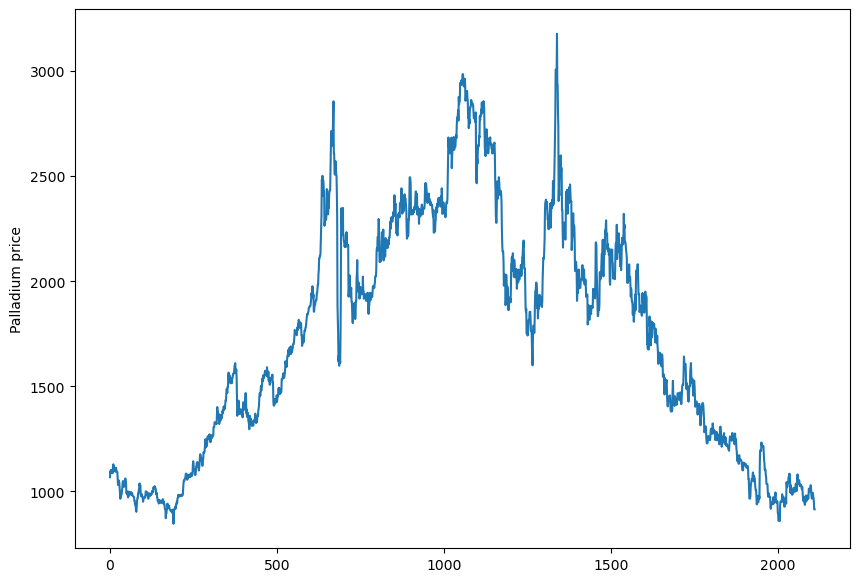

In [7]:
#Đồ thị giá đóng
df.Close.plot(figsize = (10, 7))
plt.ylabel("Palladium price")
plt.show()


In [8]:
#train test split
train_size = int(0.7 * len(df))

train_df = df[:train_size]
test_df = df[train_size:]

In [9]:
model = ETSModel(
    train_df['Close'],
    error="mul",
    trend="add",
    seasonal="mul",
    damped_trend=False,
    seasonal_periods=90)

res = model.fit()
print(res.summary())

                                 ETS Results                                  
Dep. Variable:                  Close   No. Observations:                 1477
Model:                       ETS(MAM)   Log Likelihood               -7420.097
Date:                Thu, 06 Jun 2024   AIC                          15032.194
Time:                        15:04:28   BIC                          15540.779
Sample:                             0   HQIC                         15221.807
                               - 1477   Scale                            0.000
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.024     42.432      0.000       0.954       1.046
smoothing_trend         0.0020        nan        nan        nan         nan         nan
smoothing_season

## FORECASTING

In [10]:
predicted = res.predict(start = len(train_df), end = len(train_df) + len(test_df) - 1)

In [11]:
mape = np.mean(np.abs(predicted - test_df['Close'])/np.abs(test_df['Close'])) *100
mse = np.mean(np.square(test_df['Close'] - predicted))
rmse = np.sqrt(mse)

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Percentage Error (MAPE): 52.07641191184228
Mean Squared Error (MSE): 464571.2603642832
Root Mean Squared Error (RMSE): 681.5946451992439


In [12]:
# Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Predict the closing prices for the next 90 days
y_next_90_days = res.predict(start = len(df), end = len(df) + 90 - 1)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
2110    1962.806769
2111    1961.224804
2112    1951.838342
2113    1959.903159
2114    1963.228425
           ...     
2195    1941.346742
2196    1945.695475
2197    1950.479497
2198    1956.066150
2199    1952.917395
Length: 90, dtype: float64


In [13]:
predicted

1477    2065.589804
1478    2071.515625
1479    2068.190476
1480    2063.447179
1481    2061.792285
           ...     
2105    1955.665810
2106    1960.047795
2107    1964.868285
2108    1970.497334
2109    1967.326530
Length: 633, dtype: float64

In [14]:
dt_train = np.append(train_df, predicted.iloc[0]) 

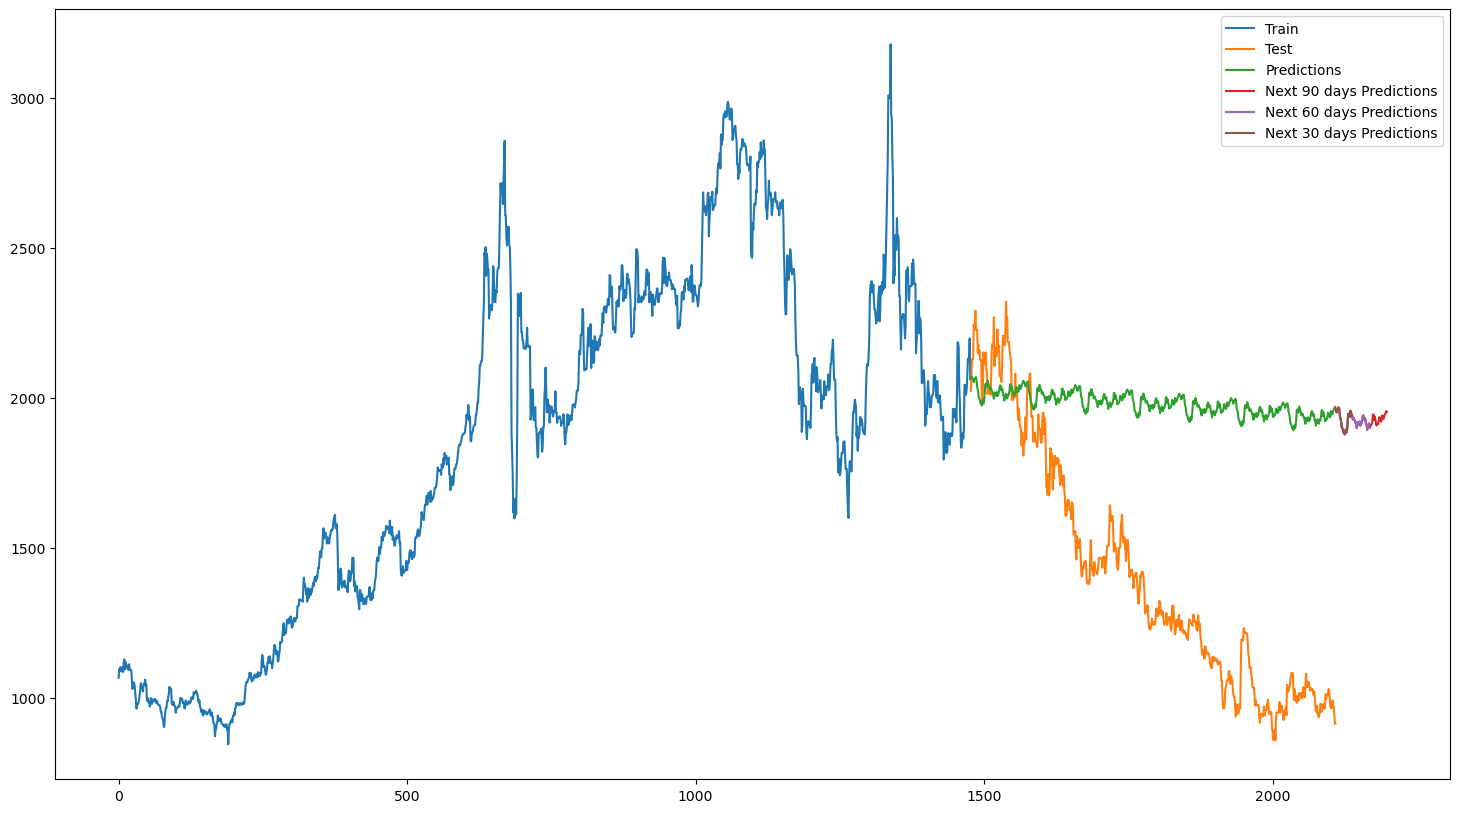

In [15]:
fig, ax = plt.subplots()

plt.plot(pd.RangeIndex(start=0, stop=len(dt_train), step=1), dt_train)
plt.plot(test_df.index, test_df)
plt.plot(test_df.index, predicted)
plt.plot(last_data,y_next_90_days)
plt.plot(pd.RangeIndex(start=last_index, stop=last_index+60, step=1),y_next_90_days[0:60])
plt.plot(pd.RangeIndex(start=last_index, stop=last_index+30, step=1),y_next_90_days[0:30])
plt.legend(['Train', 'Test', 'Predictions', 'Next 90 days Predictions', 'Next 60 days Predictions', 'Next 30 days Predictions'])
plt.show()
